In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt

In [2]:
# read data from .npy files for formaldehyde casci(8,8) calculations

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/rmandern/code/SCQED-PCQED/data/"

# these file names should still be good
E_npy_file = npy_folder + "HHep_fci_cc_pVDZ_Energies.npy"
Mu_npy_file = npy_folder + "HHep_fci_cc_pVDZ_Dipoles.npy"

# store energy eigenvalues in E_array 
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)


print(np.shape(E_array))
print(np.shape(Mu_array))
# print(Mu_array[1,1,:,:])
# print(E_array)
# print(Mu_array)

(100,)
(100, 100, 3)


In [3]:
# setup basic arguments to create an instance of the PFHamiltonianGenerator class
mol_str = """          
    H            
    He 1 0.776011            
    1 1
    symmetry c1  
"""


options_dict = {
    "basis": "cc-pVDZ",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
}


cavity_free_dict = {
    'omega_value' : 0.9760568251,
    'lambda_vector' : np.array([0, 0, 0.01]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

# create the instance of our PFHamiltonianGenerator class
instance = PFHamiltonianGenerator(mol_str, options_dict, cavity_free_dict)


Start SCF iterations:

Canonical RHF One-electron energy = -5.3139647226479543
CQED-RHF One-electron energy      = -5.3139185340151620
Nuclear repulsion energy          = 1.3638394576107813
Dipole energy                     = 0.0000006276974215
SCF Iteration   1: Energy = -2.9235932947844909   dE = -2.92359E+00   dRMS = 4.84500E-06
SCF Iteration   2: Energy = -2.9235932961991122   dE = -1.41462E-09   dRMS = 8.01056E-07
SCF Iteration   3: Energy = -2.9235932962404800   dE = -4.13678E-11   dRMS = 5.60419E-08
SCF Iteration   4: Energy = -2.9235932962406657   dE = -1.85629E-13   dRMS = 3.88673E-09
SCF Iteration   5: Energy = -2.9235932962406683   dE = -2.66454E-15   dRMS = 7.59757E-11
Total time for SCF iterations: 0.001 seconds 

QED-RHF   energy: -2.92359330 hartree
Psi4  SCF energy: -2.92363917 hartree
 Completed QED-RHF in 0.19090890884399414 seconds
 Completed 1HSO Build in 8.0108642578125e-05 seconds
 Completed ERI Build in 0.0012969970703125 seconds 
 Completed 2D build in 0.000747

In [4]:
print(E_array)

[-2.96082056 -2.16533574 -1.98476373 -1.64762091 -1.58323414 -1.12366468
 -1.12366468 -1.09549003 -1.0026547  -1.0026547  -0.86892779 -0.7006448
 -0.45854289 -0.35175526 -0.27645472 -0.17469485  0.05261434  0.05261434
  0.12043252  0.18212832  0.18212832  0.18533166  0.18533166  0.22506633
  0.28919361  0.45824772  0.45824772  0.64455796  0.65378037  0.65378037
  0.67918948  0.67918948  0.78842239  0.79223251  1.01950037  1.12635068
  1.12635068  1.1569179   1.1569179   1.17514143  1.19153124  1.19153124
  1.23718228  1.24362234  1.24362234  1.26834614  1.30359324  1.32244835
  1.32244835  1.32612044  1.34625431  1.54757396  1.7149387   1.7149387
  1.73395657  1.73395657  1.7797436   1.82833267  1.82833267  1.8744769
  1.92872575  1.92872575  2.10834553  2.12416954  2.12416954  2.14167147
  2.25914893  2.25914893  2.30157253  2.30157253  2.31372035  2.40346055
  2.40742287  2.40742287  2.42489284  2.53334429  2.72134308  2.87914407
  2.87914407  2.9048408   2.9148122   2.9148122   2.97

In [5]:
# Define the range and increment
start = 0.025
stop = 0.1
increment = 0.005

# Create the array using numpy's arange function
lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


N_l = len(lambda_array)
N_el = 60
N_ph = 10
omega = 0.9760568251

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_22 = np.zeros((N_l, N_el * N_ph))

ctr = 0
# loop over the lambda values
for i, lambda_val in enumerate(lambda_array):
    lambda_vector = np.array([0, 0, lambda_val])
    instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector, E_array, Mu_array)      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
    ctr += 1


In [6]:
# Saving energies in numpy array form
E_pcqed_array = np.array(_pcqed_22)

# Making list from the array
E_list = E_pcqed_array.tolist()

# Making list of lambda value from array
lamda_val = lambda_array.tolist()

# Giving [x, y, z] form to the list
lambda_values = [[0, 0, round(val,3)] for val in lamda_val]

# set up base dictionary - some of this will be updated with each calculation
dictionary = {   
    "molecule": {
        "molecule_name": "HHe+",
        "geometry": [
            "\nH       \nHE            1    0.776011\n1 1\nsymmetry c1\n"
        ],
        "symbols": [
            "H",
            "He"
        ]
    },
       
        "basis_set" : "cc-pVDZ",
        "Photon basis" : "photon_number_basis", 
        "Number Photon States" : 10,
        "driver": "energy",
        "method" : "PCQED",
        "lambda" : lambda_values
                        ,
         "omega_value" : '0.9760568251',
    
        "return_result" : E_list,
}


# function to generate file names based on system details
def generate_file_name(dic):
    
    file_name = dic["molecule"]["molecule_name"] + "_"
    file_name += str(dictionary["basis_set"]) + "_"
    file_name += str(dictionary["method"]) + "_"
    file_name += str(dictionary["Number Photon States"]) + "_"
    file_name += str(dictionary["omega_value"]) + ".json"
    return file_name

In [7]:
# write to json file
file_name = generate_file_name(dictionary)
json_object = json.dumps(dictionary, indent=4)
with open(file_name, "w") as outfile:
    outfile.write(json_object)

In [8]:
# dim = np.ndim(_pcqed_22)
# print(np.shape(_pcqed_22))
# print(np.shape(_pcqed_22[1,:]))
# print(np.ndim(_pcqed_22[:,1]))
# print(_pcqed_22)
# print(_pcqed_22[0,:])
print(_pcqed_22[:,0])


[-2.96068517 -2.96062561 -2.96055522 -2.96047401 -2.96038198 -2.96027913
 -2.96016547 -2.96004099 -2.95990571 -2.95975962 -2.95960273 -2.95943505
 -2.95925658 -2.95906732 -2.95886729 -2.95865648 -2.95843491]


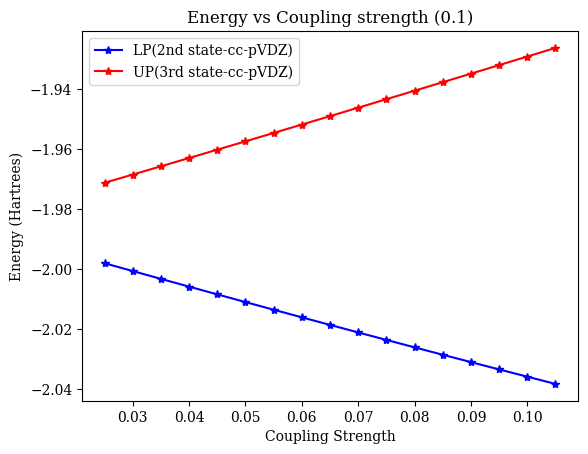

In [16]:
from matplotlib import cm
from matplotlib import rcParams



# plt.plot(lambda_array, _pcqed_22[:,0],'k-', marker="*", label= "Ground State")
# plt.plot(lambda_array, _pcqed_22[:,1], 'm-', marker="*",label = "1st excited state")
plt.plot(lambda_array, _pcqed_22[:,2],'b-', marker="*", label = "LP(2nd state-cc-pVDZ)")
plt.plot(lambda_array, _pcqed_22[:,3],'r-', marker="*", label = "UP(3rd state-cc-pVDZ)")
plt.legend()
plt.ylabel('Energy (Hartrees)')
plt.xlabel('Coupling Strength')

plt.savefig("Energy vs Coupling strength for cc-pVDZ zoomedlambda_0dot1", dpi=150,bbox_inches='tight')
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10
# plt.gca().yaxis.set_major_formatter('{:.12f}'.format)
#plt.plot(A0_list, e4, label = "E4")
plt.title("Energy vs Coupling strength (0.1)")
plt.show()

In [ ]:
import json

E_pcqed_array = np.array(_pcqed_22)
# E_list = E_pcqed_array.tolist()
# np.save("HeHp_cc-pVDZ-PCQED" + str(lambda_array[i]).replace(".", "_") , E_pcqed_array)
E_list = E_pcqed_array.tolist()
# print(E_list)
# Create an empty dictionary to store energy arrays for different lambda values
energy_arrays = {}

# Iterate over lambda_array
for i, lambda_val in enumerate(lambda_array):
    # Construct key for the energy array corresponding to lambda_val
    key = "energy_array_" + str(lambda_val).replace(".", "_")
    
    # Store the energy array in the dictionary
    energy_arrays[key] = E_list
# print(energy_arrays)
# Construct the main dictionary
dictionary = {
    "molecule": {
        "molecule_name": "HHe+",
        "geometry": [
            "\nH       \nHe            1    0.776011\n1 1\nsymmetry c1\n"
        ],
        "symbols": [
            "H",
            "He"
        ]
    },
    "omega_value": '0.9760568251',
    "basis_set": "cc-pVDZ",
    "Photon_basis": "photon_number_basis",
    "Number_Photon_States": 10,
    "energy_arrays": energy_arrays  
}

# Save the dictionary as JSON
file_name = "HeHp_cc-pVDZ-PCQED-10-omega-0.9760568251"
json_object = json.dumps(dictionary, indent=4)
with open(file_name + ".json", "w") as outfile:
    outfile.write(json_object)


In [ ]:
# # Define the range and increment
# start = 0.0
# stop = 0.02
# increment = 0.001

# # Create the array using numpy's arange function
# lambda_array = np.arange(start, stop + increment, increment)
# print(lambda_array)
# print(len(lambda_array))


# N_R = 21
# d_array = np.linspace(1.4,2.2,N_R)
# N_l = len(lambda_array)
# N_el = 10
# N_ph = 2
# omega = 0.9760568251

# # create an array of zeros to store the PCQED eigenvalues for each value of d
# _pcqed_22 = np.zeros((len(lambda_array),N_l, N_el * N_ph))

# # loop over the lambda values
# for i, lambda_val in enumerate(lambda_array):
#     lambda_vector = np.array([0, 0, lambda_val])
#     ctr = 0
#     for d in d_array:
#         instance.fast_build_pcqed_pf_hamiltonian(N_el, N_ph, omega, lambda_vector , E_array[:,ctr], Mu_array[:,:,:,ctr])      # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
#         _pcqed_22[ctr, :] = instance.PCQED_pf_eigs
#         ctr += 1
